# Illustrating the Double-Wilson model using synthetic data

# Introduction

The structure factors amplitudes (SFAs) of related structures are likely to be correlated. We should be able to exploit this correlation during scaling and merging by constraining the optimization more strongly than by the requirement that structure factors following a Wilson distribution. 

The Wilson distribution derives from a model where each structure factor derives from a 1D (centric) or 2D (acentric) random walk on the real axis (centric) or the complex plane (acentric). The amplitudes thereof follow the Wilson distributions. A natural extension would be for the corresponding structure factors of two datasets to perform correlated random walks, resulting in a joint multivariate normal distribution of the real and complex components of the (complex) structure factors of the two data sets. The resulting conditional distributions for structure factor amplitudes are the Woolfson or Folded-normal (centric) and Rice (acentric) distributions as described by Rupp Ch 7.

First, in **Mapping from Double-Wilson $r$ to Pearson correlation for $|E|$**, we find that the Pearson correlation for two sets of SFAs is approximately $r_{DW}^2$. After this result, in **Generate and inspect synthetic data** we draw samples from the Double-Wilson distribution and verify the correspondence of our models (derived in **notebook 6**) to the unconditional and conditional distributions of acentric and centric SFAs.

<!---A key point revealed by the analysis is that the parameter $r_{DW}$ used in the Double-Wilson model is a function of resolution and seems to be well described by the Luzzati model on p. 903 in Read (1990), "Structure-Factor Probabilities for Related Structures". --->

**PS**: Although Read's paper is focused on correlations between Fc's rather than Fobs's, its entire analytical apparatus carries over to our case with:

- $r_{DW} = \textbf{D}$ (or $\sigma_E$ in eqs. 28-30).
- his $\textbf{s}$ equal to the reciprocal lattice point vector which we calculate below as ```(rs_a, rs_b, rs_c)```.
- his $\sigma^2_{\Delta}$ related to our conditional variance $\frac{1}{2}(1-r_{DW}^2)$.

**Notation**
- we will use $hkl$ and ```HKL```
- we will denote reciprocal lattice point coordinates as ```(rs_a,rs_b,rs_c)``` and $r*$, with magnitude $1/d_{hkl}$ or ```dHKL```. The scattering vector $s=S_1-S_0$ equals $r*$ in our case (elastic scattering).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np
import pandas  as pd
from tqdm      import tqdm
plt.rcParams.update({'font.size': 14})

In [2]:
import reciprocalspaceship as rs
import gemmi
from dw_tools       import modify_ds, wilson, plots, fitting_dw
from scipy.optimize import least_squares
from scipy.stats    import rice, foldnorm, vonmises, linregress, pearsonr

In [3]:
#%autosave 300
#%load_ext autoreload
#%autoreload 2
rs.__version__

'1.0.1'

# Mapping from double-wilson $r_{DW}$ to Pearson corr for $|E|$
We start by making sure we understand the mapping between the parameter $r_{DW}$ in the Double-Wilson distribution and the actual correlation coefficient between pairs of structure factor amplitudes. To do so, we will analyze samples drawn from the Double-Wilson distribution described by different values of $r_{DW}$. For a pair of complex (acentric) structure factor amplitudes, we sample from a 4D normal distribution with correlations between their respective real components, and correlations between their respective imaginary components, both captured by a scalar coefficient `r`. We do not assume any correlation between real and imaginary components in any way.

In [4]:
nsamples= 5000000
nbin_r  = 20                        # number of values of r_DW to use
r       = np.linspace(0,1,nbin_r)   # r_DW; correlation between random walks 
mean    = [0,0,0,0]                 # mean of random walks (real, imag for F1, real, imag for F2)

# ACENTRIC CASE
corr_r_ac = np.zeros([nbin_r,1])    # correlation between |F_1| and |F_2| samples from DW (acentric)
for i in tqdm(range(nbin_r)):
    cov     = 0.5*np.asarray([[1,   0,   r[i],0   ],\
                              [0,   1,   0,   r[i]],\
                              [r[i],0,   1,   0   ],\
                              [0,   r[i],0,   1   ]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)
    # synthetic data set (acentric)
    ep1_test = np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 ) # |F1|
    ep2_test = np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 ) # |F2|
    corr_r_ac[i] = pearsonr(ep1_test, ep2_test)[0]

print("variance of sf acentric amplitudes from the DW distribution:" + \
     str(np.var(np.concatenate((ep1_test,ep2_test)))))
    
# CENTRIC CASE
corr_r_c = np.zeros([nbin_r,1])
for i in tqdm(range(nbin_r)):
    cov     = 0.5*np.asarray([[1,   0,   r[i],0   ],\
                              [0,   1,   0,   r[i]],\
                              [r[i],0,   1,   0   ],\
                              [0,   r[i],0,   1   ]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)
    # synthetic data set (centric)
    ep1_test = np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,0]**2 ) #|F1|
    ep2_test = np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,2]**2 ) #|F2|
    corr_r_c[i] = pearsonr(ep1_test, ep2_test)[0]

print("variance of sf acentric amplitudes from the DW distribution:" + \
     str(np.var(np.concatenate((ep1_test,ep2_test)))))
print("Done!")

100%|███████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]


variance of sf acentric amplitudes from the DW distribution:0.21455137218150133


100%|███████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]

variance of sf acentric amplitudes from the DW distribution:0.36395131203704395
Done!


A quick check of our math for the inverse covariance matrix for the structure factor components.

In [5]:
rp = 0.8
cov= np.asarray([[1, 0,rp, 0],\
                 [0, 1, 0,rp],\
                 [rp,0, 1, 0],\
                 [0, rp,0, 1]])
print(np.array2string(np.linalg.inv(cov)))
print(1/(1-rp**2))

[[ 2.77777778  0.         -2.22222222  0.        ]
 [ 0.          2.77777778  0.         -2.22222222]
 [-2.22222222  0.          2.77777778  0.        ]
 [ 0.         -2.22222222  0.          2.77777778]]
2.7777777777777786


The inverse of 

$$
C = 
\begin{bmatrix}
1 & 0 & r & 0        \\
0 & 1 & 0 & r        \\
r & 0 & 1 & 0        \\
0 & r & 0 & 1 
\end{bmatrix}
$$
is
$$
C^{-1} = \frac{1}{1-r^2}
\begin{bmatrix}
1  & 0  & -r & 0        \\
0  & 1  & 0  & -r       \\
-r & 0  & 1  & 0        \\
0  & -r & 0  & 1 
\end{bmatrix}
$$

In [1]:
plt.figure(figsize=(4,2.5))
plt.hist(ep1_test,density=True,bins=100)
plt.title('Example distribution of (centric) |F| under the model')
plt.show()

NameError: name 'plt' is not defined

It is not _a priori_ obvious what the relationship between the parameter $r_{DW}$ above and the correlation coefficient of the sf amplitudes should be. Below we'll see that $\rho(|F_1|,|F_2|)\approx r_{DW}^2$, but this is not exact.

In [9]:
from scipy.linalg import lstsq
M = r[:,np.newaxis]**[2,4,6,8]
beta_ac, res, rnk, s = lstsq(M,corr_r_ac)
beta_c,  res, rnk, s = lstsq(M,corr_r_c )

def r_dw_to_r_E(r,beta):
    X=np.array([r**2,r**4,r**6,r**8]).transpose()
    return np.dot(X,beta)

# despite this function, we'll use the square root as our proxy as it is trivial to invert.
# the coefficients of the least-square fit are quite variable, even with 500,000 samples.

print(beta_ac.transpose())
print(beta_c.transpose())

[[ 0.91156367  0.0743919  -0.02562174  0.03953969]]
[[ 0.87151537  0.1222901  -0.11097471  0.11675352]]


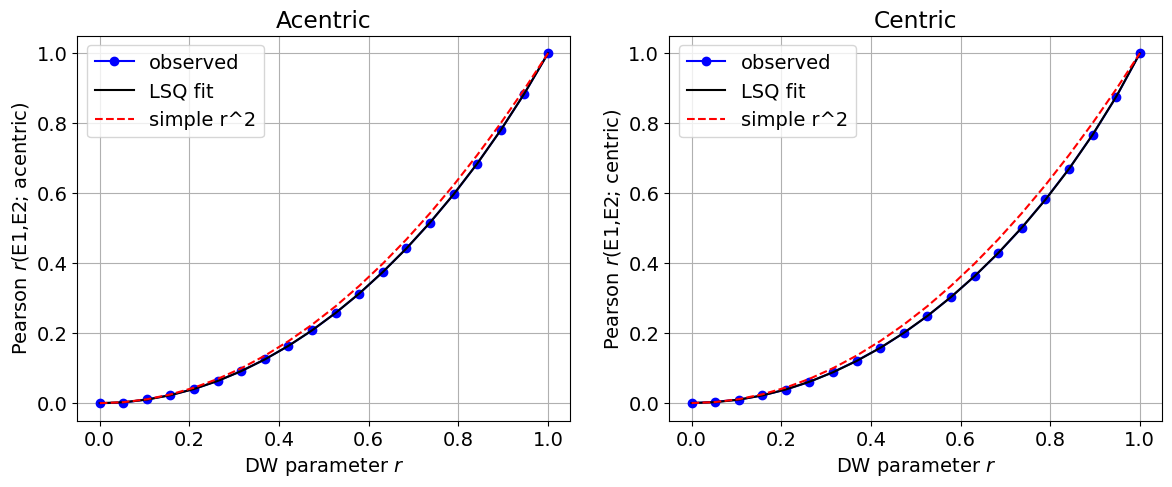

/tmp/ipykernel_798387/3164153944.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(corr_r_ac, np.sqrt(corr_r_ac+0.15*(corr_r_ac**2-corr_r_ac**3)),'k-')
/tmp/ipykernel_798387/3164153944.py:30: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(corr_r_ac, np.sqrt(corr_r_ac),'r--')
/tmp/ipykernel_798387/3164153944.py:38: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(corr_r_c, np.sqrt(corr_r_c+0.3*(corr_r_c**2-corr_r_c**3)),'k-')
/tmp/ipykernel_798387/3164153944.py:39: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(corr_r_c, np.sqrt(corr_r_c),'r--')


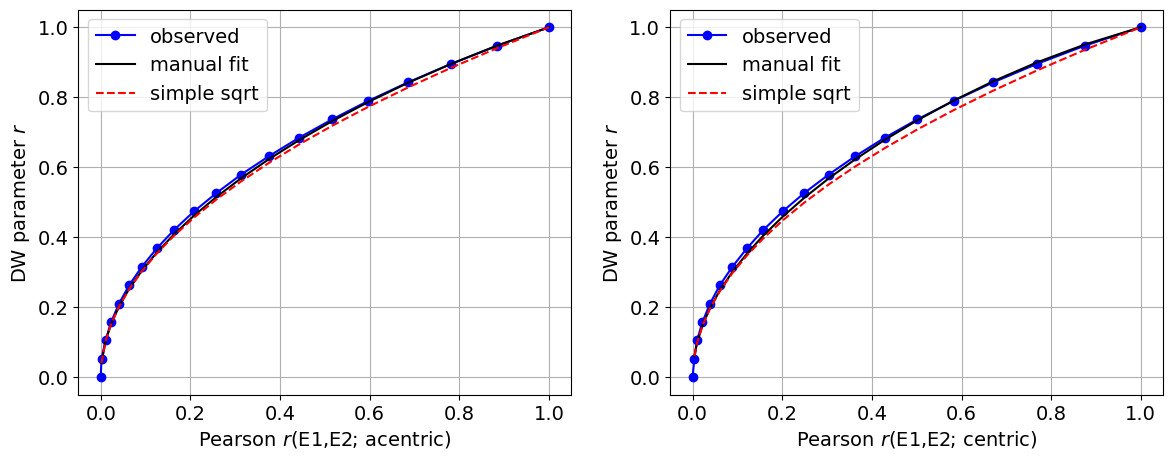

In [10]:
bPlot=True
if bPlot:
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)                       # Empirical and least-squares-fit mapping from r to pearson(E1,E2)
    plt.plot(r,corr_r_ac,'bo-')              # ACENTRIC
    plt.plot(r,r_dw_to_r_E(r,beta_ac),'k-')
    plt.plot(r,r**2,'r--')
    plt.legend(["observed","LSQ fit","simple r^2"])
    plt.xlabel("DW parameter $r$")
    plt.ylabel("Pearson $r$(E1,E2; acentric)")
    plt.title("Acentric")
    plt.grid()

    plt.subplot(1,2,2)                      # CENTRIC
    plt.plot(r,corr_r_c,'bo-')
    plt.plot(r,r_dw_to_r_E(r,beta_c),'k-')
    plt.plot(r,r**2,'r--')
    plt.legend(["observed","LSQ fit","simple r^2"])
    plt.xlabel("DW parameter $r$")
    plt.ylabel("Pearson $r$(E1,E2; centric)")
    plt.title("Centric")
    plt.grid()
    plt.show()

    # now the inverse
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)                       # Empirical and least-squares-fit mapping from r to pearson(E1,E2)
    plt.plot(corr_r_ac,r,'bo-')              # ACENTRIC
    plt.plot(corr_r_ac, np.sqrt(corr_r_ac+0.15*(corr_r_ac**2-corr_r_ac**3)),'k-')
    plt.plot(corr_r_ac, np.sqrt(corr_r_ac),'r--')
    plt.legend(["observed","manual fit","simple sqrt"])
    plt.ylabel("DW parameter $r$")
    plt.xlabel("Pearson $r$(E1,E2; acentric)")
    plt.grid()

    plt.subplot(1,2,2)                       # CENTRIC
    plt.plot(corr_r_c,r,'bo-')
    plt.plot(corr_r_c, np.sqrt(corr_r_c+0.3*(corr_r_c**2-corr_r_c**3)),'k-')
    plt.plot(corr_r_c, np.sqrt(corr_r_c),'r--')
    plt.legend(["observed","manual fit","simple sqrt"])
    plt.ylabel("DW parameter $r$")
    plt.xlabel("Pearson $r$(E1,E2; centric)")
    plt.grid()
    plt.show()

**Conclusion:** 
In good approximation, when a pair of normalized structure factors is drawn from an acentric Double-Wilson distribution, they have a correlation coefficient $r^2_{DW}$, with $r_{DW}$ parametrizing the DW distribution. This approximation is slightly worse for centric reflections.

# Generate and inspect synthetic data

## Generate and inspect synthetic Acentric data
We confirm that the Wilson distribution for acentric normalized structure factor amplitudes is identical with the Rice distribution (`rice.pdf(x,0,scale=np.sqrt(0.5))`) and that we know how to parametrize both.

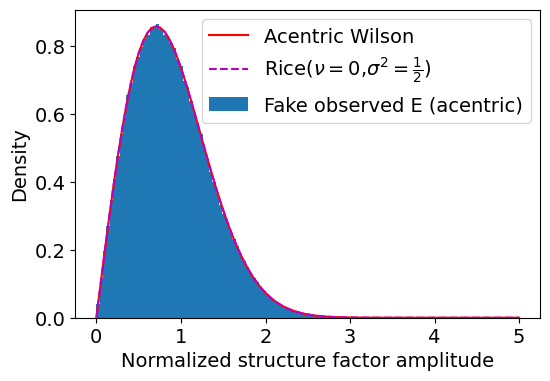

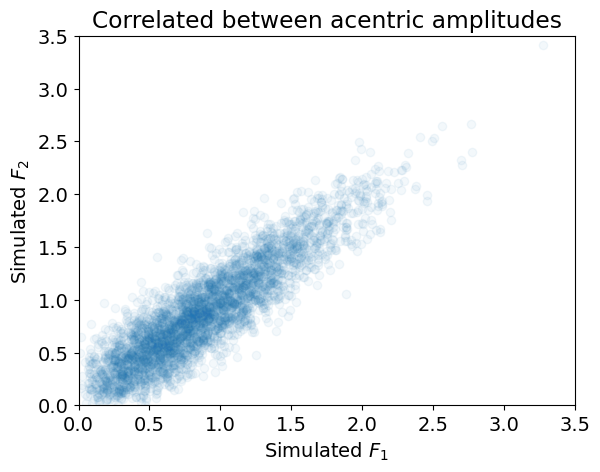

In [12]:
nsamples= 1000000
nbin    = 25
x       = np.linspace(0,5,100) # x-coordinates for plots
r_fake  = 0.95                 # correlation between random walks 
r       = r_fake
mean    = [0,0,0,0]            # mean of random walks
cov     = 0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])

E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)

# synthetic data set (acentric)
ds_test =         pd.DataFrame(np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 ), columns = ["EP_1"])
ds_test["EP_2"] = pd.DataFrame(np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 ))

# graphical inspection
plt.figure(figsize=(6,4))
plt.hist(ds_test["EP_1"].to_numpy(),100,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x, centric=False),'r-')
plt.plot(x, rice.pdf(x,0,scale=np.sqrt(0.5)),'m--')
plt.legend(["Acentric Wilson", r"Rice($\nu=0$,$\sigma^2=\frac{1}{2}$) ", "Synthetic observed E (acentric)"])
plt.xlabel("Normalized structure factor amplitude")
plt.ylabel("Density")
plt.show()

plt.title("Correlated between acentric amplitudes")
plt.scatter(np.sqrt(E_1x_1y_2x_2y[:3500,0]**2 +E_1x_1y_2x_2y[:3500,1]**2 ),\
            np.sqrt(E_1x_1y_2x_2y[:3500,2]**2 +E_1x_1y_2x_2y[:3500,3]**2 ),alpha=0.05)
# ax.axis ('equal')
plt.ylim((0,3.5)); plt.xlim([0,3.5]);
plt.xlabel(r"Synthetic $F_1$")
plt.ylabel(r"Synthetic $F_2$")
plt.show()

The structure factor amplitudes follow a Rice distribution, as expected. 

Example 2D histogram for the `r_fake` above:

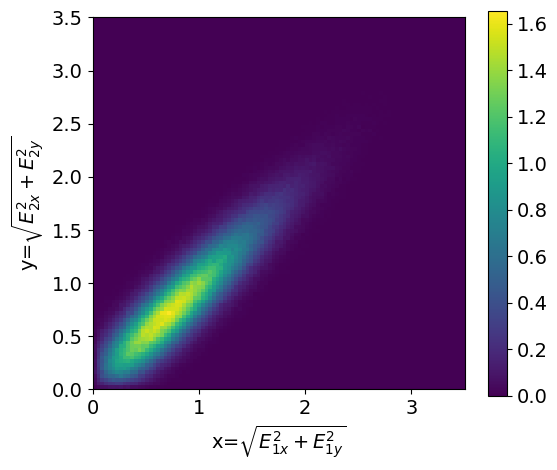

In [13]:
xy_max = 3.5
nx=100
ny=100
(xmax,ymax) = (xy_max,xy_max)
xedges = np.linspace(0,xmax,nx+1)
yedges = np.linspace(0,ymax,ny+1)
Hx_emp, xedges, yedges = np.histogram2d(ds_test["EP_1"], ds_test["EP_2"], bins=(xedges, yedges),density=True)

plt.figure(figsize=(6,5))                         
plt.imshow(Hx_emp, interpolation='none', extent=[0,xmax,0,ymax],origin='lower')
plt.xlabel(r"x=$\sqrt{E_{1x}^2+E_{1y}^2}$"); plt.ylabel(r"y=$\sqrt{E_{2x}^2+E_{2y}^2}$")
plt.colorbar(); 

## Generate and inspect synthetic Centric data

EP_1    0.797914
EP_2    0.797883
dtype: float64


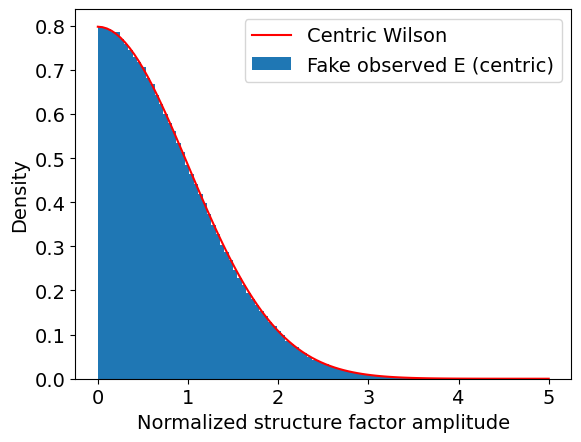

In [14]:
# synthetic data set (centric)
# mind the sqrt(2)! we normalize, in effect, by the rms acentric amplitude
ds_test_cent = pd.DataFrame(        np.sqrt(2*E_1x_1y_2x_2y[:,0]**2), columns = ["EP_1"])
ds_test_cent["EP_2"] = pd.DataFrame(np.sqrt(2*E_1x_1y_2x_2y[:,2]**2))

print(ds_test_cent.mean())
# graphical inspection
plt.figure()
plt.hist(ds_test_cent["EP_2"].to_numpy(),100,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x, centric=True),'r-')
plt.legend(["Centric Wilson", "Synthetic observed E (centric)"])
plt.xlabel("Normalized structure factor amplitude")
plt.ylabel("Density")
plt.show()

The |E| follow a folded normal distribution, as expected. 

## Conditional distribution for Acentrics. 

We check the agreement between the synthetic data and the conditional distribution of $|E_2|$ given $|E_1|$, first for acentric reflections and then for centric reflections.

### Step 1: means per bin for $|E_1|$.

In [ ]:
cdf_bins = np.linspace(0,100,nbin+1)
ep1_bins = np.percentile(ds_test["EP_1"], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig  = np.digitize(ds_test["EP_1"], ep1_bins)
ds_test["EP_1_bin"] = ep1_dig.flatten()

unique, counts = np.unique(ds_test["EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin:")
print(temp)

bin_means=ds_test.groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means,'bo-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.grid(True)
plt.ylim(0,)
plt.show()

NameError: name 'np' is not defined

### Step 2: histograms of $|E_2|$ per bin of $|E_1|$.
The calculations of the parameters for the Rice distribution are shown in **notebook 6**. 

The conditional mean     $\mathbb{E}\left(E_2 | E_1\right) = r_{DW} E_1$ (for both centric and acentric; true for amplitudes and complex structure factors).

The conditional variance $\textrm{Var}\left(|E_2| | |E_1| \right) = \frac{1}{2}\left(1-r_{DW}^2\right)$ (acentric)
or                                                                           $\left(1-r_{DW}^2\right)$ (centric),
where the twice-as-large conditional variance for centrics is inherent in how they are calculated.

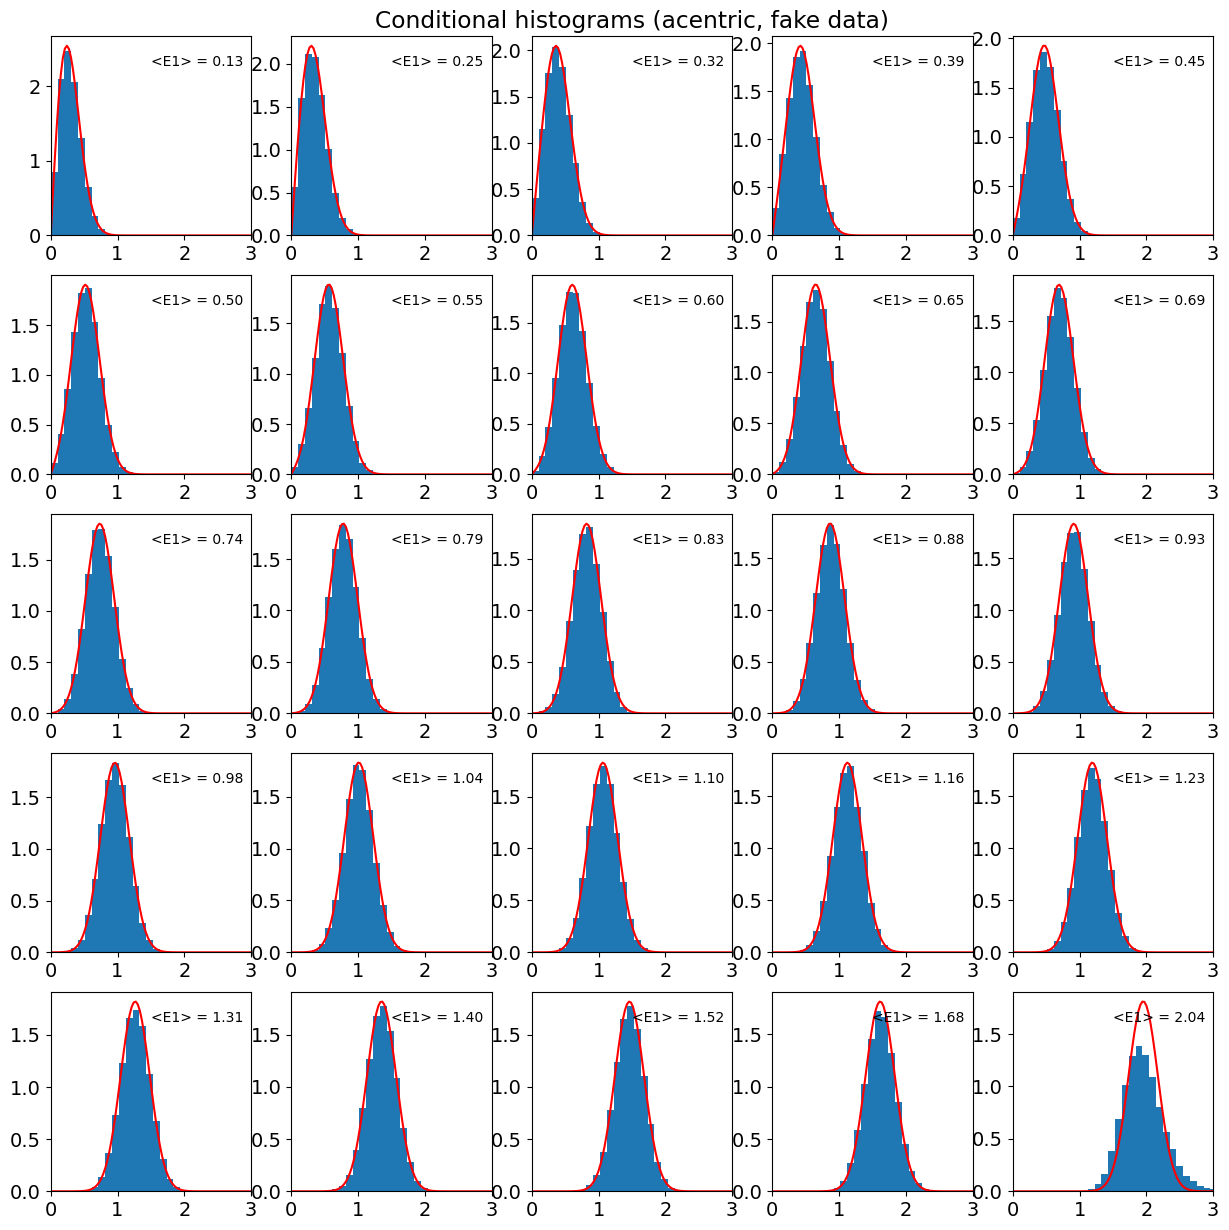

In [16]:
plt.figure(figsize=(15,15)) 
x=np.linspace(0,3,100)
counter = 0
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    r1 = r_fake*bin_means[i]     # conditional exp value
    cond_var = 0.5*(1-r_fake**2) # conditional var for acentrics

    plt.hist(ds_test.loc[ds_test["EP_1_bin"]==i,"EP_2"],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    yl=plt.ylim()
    xl=[0,3] 
    plt.text(1.5,0.85*yl[1],f"<E1> = {bin_means[i]:.2f}",size=10)
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms (acentric, synthetic data)")
plt.show()

There is good agreement between our conditional distribution pdf and the synthetic data, except for the last $|E_1|$ bin. This could be the result of sampling errors. 

#### Illustrating how the Rice distribution interpolates between the reference and the Wilson disitrbution
We take a detailed closeup of a few of the above histograms.  
- **Black**: the average reference value in a bin; 
- Blue:  the unconditional mean (i.e. the Wilson mean); 
- Red:   the conditional mean

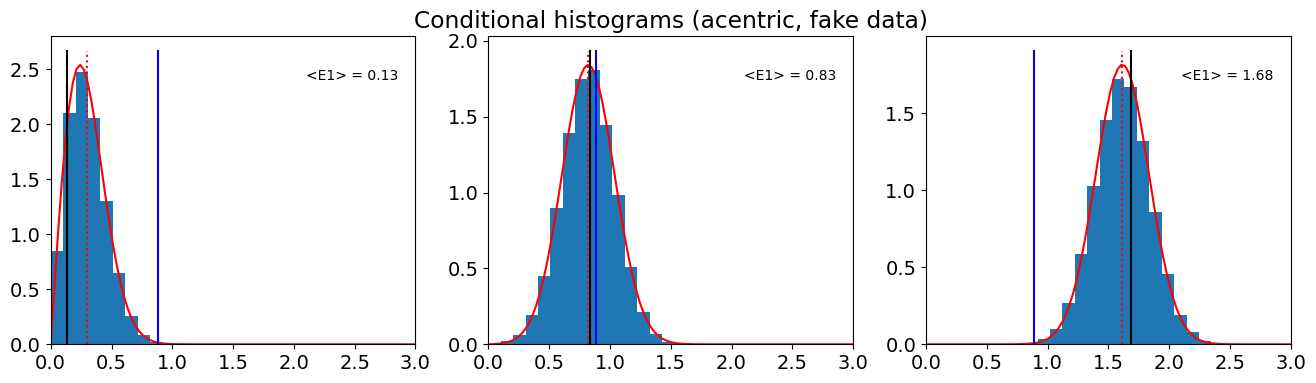

In [17]:
plt.figure(figsize=(16,4))
x=np.linspace(0,3,100)
counter = 0
for i in [1, 13, 24]:
    counter += 1             # for illustration purposes.
    plt.subplot(1,3,counter) # for illustration purposes.
    r1 = r_fake*bin_means[i]     # conditional exp value
    cond_var = 0.5*(1-r_fake**2) # conditional var for acentrics
    
    plt.hist(ds_test.loc[ds_test["EP_1_bin"]==i,"EP_2"],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    yl=plt.ylim()

#    to illustrate the idea of Rice interpolating between Wilson and delta function:
    plt.plot(bin_means[i]*np.asarray([1, 1]),yl,'k-')
    plt.plot(rice.mean(0,scale=1/np.sqrt(2))*np.asarray([1,1]),yl,'b-')
    plt.plot(rice.mean(r1/np.sqrt(cond_var),scale=np.sqrt(cond_var))*np.asarray([1,1]),yl,'r:')
    xl=[0,3] #plt.xlim()
    plt.text(2.1,0.9*yl[1],f"<E1> = {bin_means[i]:.2f}",size=10)
    plt.xlim(xl)
    if counter == 2:
        plt.title("Conditional histograms (acentric, synthetic data)")

plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

We see that the conditional mean is much better than the unconditional mean for approximatiing the average reference value.

## Conditional distribution for Centrics. 

We repeat the above analysis but for centric reflections. 

### Step 1: means per bin for $|E_1|$.

Number of reflections per bin:
{1: 40000, 2: 40000, 3: 40000, 4: 40000, 5: 40000, 6: 40000, 7: 40000, 8: 40000, 9: 40000, 10: 40000, 11: 40000, 12: 40000, 13: 40000, 14: 40000, 15: 40000, 16: 40000, 17: 40000, 18: 40000, 19: 40000, 20: 40000, 21: 40000, 22: 40000, 23: 40000, 24: 40000, 25: 40000}


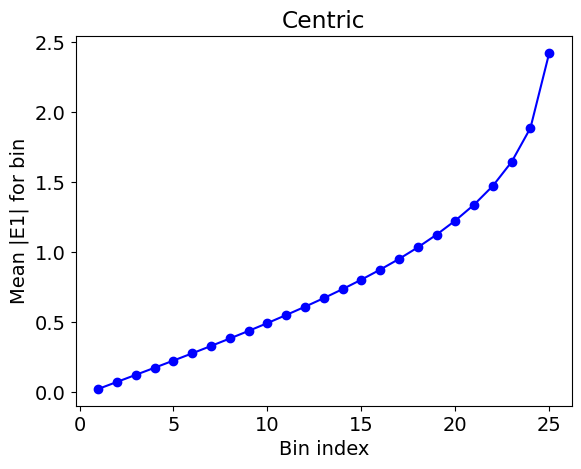

In [18]:
cdf_cent_bins     = np.linspace(0,100,nbin+1)
ep1_cent_bins     = np.percentile(ds_test_cent["EP_1"], cdf_cent_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_cent_dig  = np.digitize(ds_test_cent["EP_1"], ep1_cent_bins)
ds_test_cent["EP_1_bin"] = ep1_cent_dig.flatten()

unique, counts = np.unique(ds_test_cent["EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin:")
print(temp)

bin_means_cent=ds_test_cent.groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means_cent,'bo-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.title("Centric")
plt.show()

### Step 2: histograms of $|E_2|$ per bin of $|E_1|$.

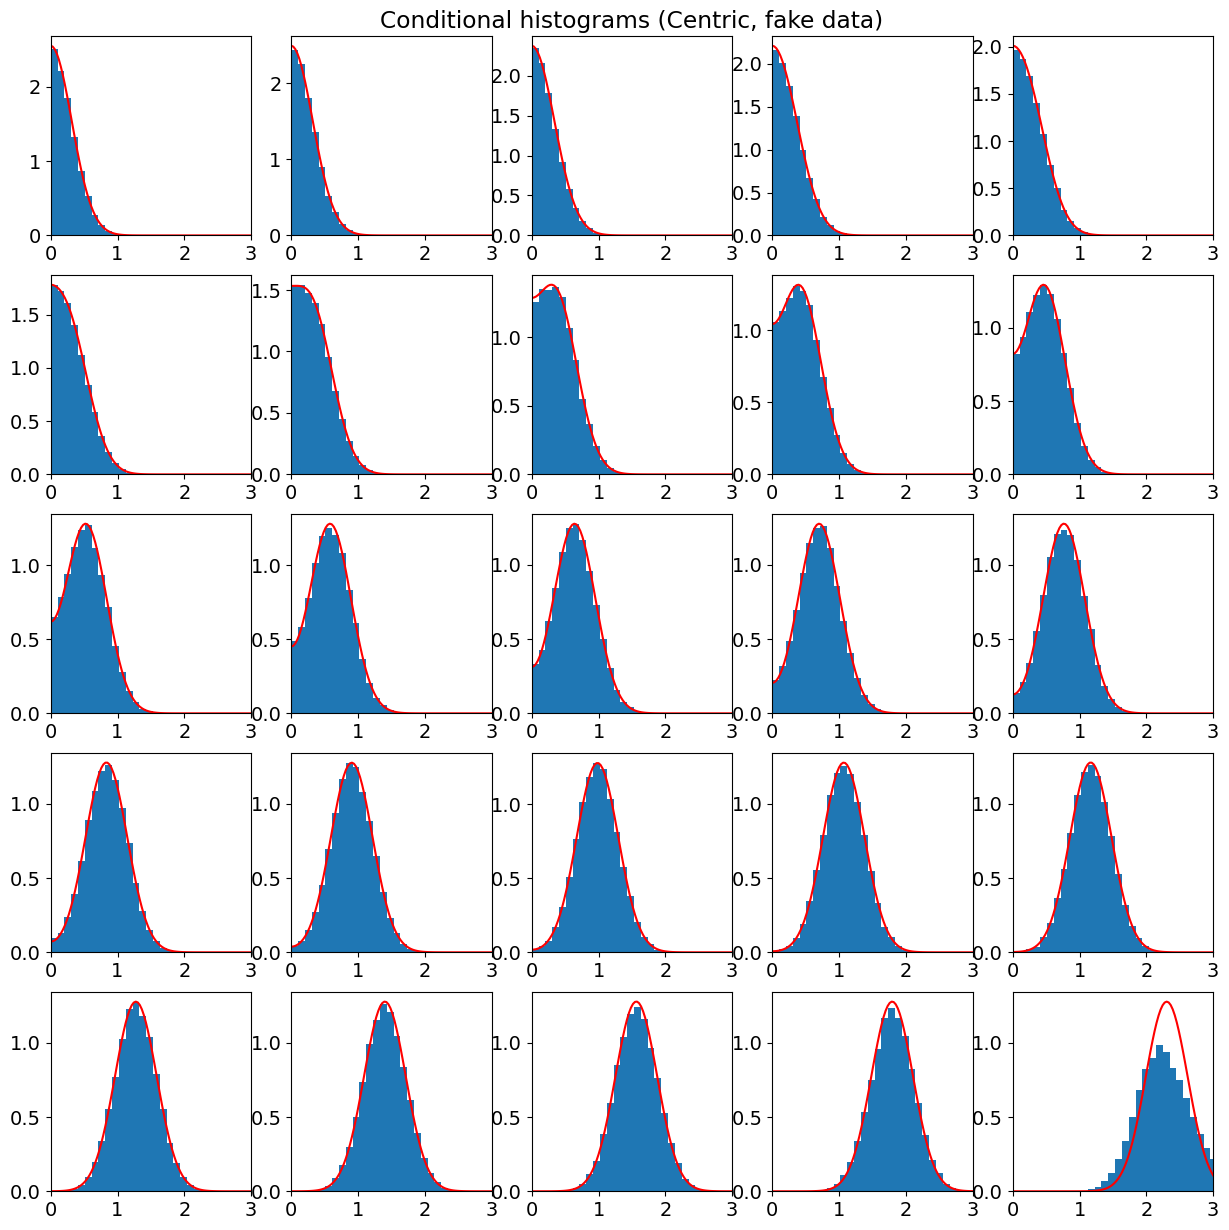

In [19]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    r1 = r_fake*bin_means_cent[i] # conditional exp value
    cond_var = (1-r_fake**2)      # no 0.5* for centrics!
    plt.hist(ds_test_cent["EP_2"][ds_test_cent["EP_1_bin"]==i],np.linspace(0,5,50),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] #plt.xlim()
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms (Centric, synthetic data)")
plt.show()

There is good agreement between our conditional distribution pdf and the synthetic data, except for the last $|E_1|$ bin. This could be the result of sampling errors. 